In [80]:
from duckduckgo_search import DDGS
from fastcore.all import *
import shutil

def search_images(term, max_images=200): return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [81]:
from fastdownload import download_url
from fastai.vision.all import *

data/supra car.jpg


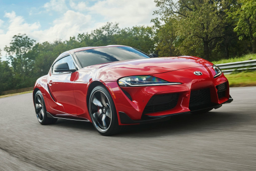

data/ferrari car.jpg


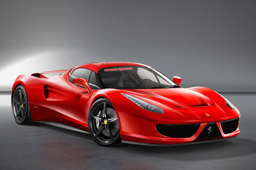

In [82]:
categories = ['supra car', 'ferrari car']
data_dir = Path('data')
if data_dir.exists():
    shutil.rmtree(data_dir)
training_data_dir = data_dir/'training_data'
training_data_dir.mkdir(parents=True)
for category in categories:
    dest = data_dir/f"{category}.jpg"
    url = search_images(category, max_images=1)[0]
    download_url(url, dest, show_progress=False)
    print(dest)
    display(Image.open(dest).to_thumb(256,256))


In [83]:
for search_term in categories:
    print(f"Downloading {search_term} images")
    dest = training_data_dir/search_term
    dest.mkdir(parents=True, exist_ok=True)
    download_images(dest=dest, urls=search_images(search_term, max_images=205))
    failed = verify_images(get_image_files(dest))
    failed.map(Path.unlink)
    files_downloaded = len(os.listdir(dest))
    print(f"Files downloaded: {files_downloaded}")
    print(f"Files failed: {len(failed)}")

    for file in os.listdir(dest)[:5]:
        shutil.move(dest/file, data_dir)
    

Files downloaded: 175
Files failed: 9
Files downloaded: 193
Files failed: 4


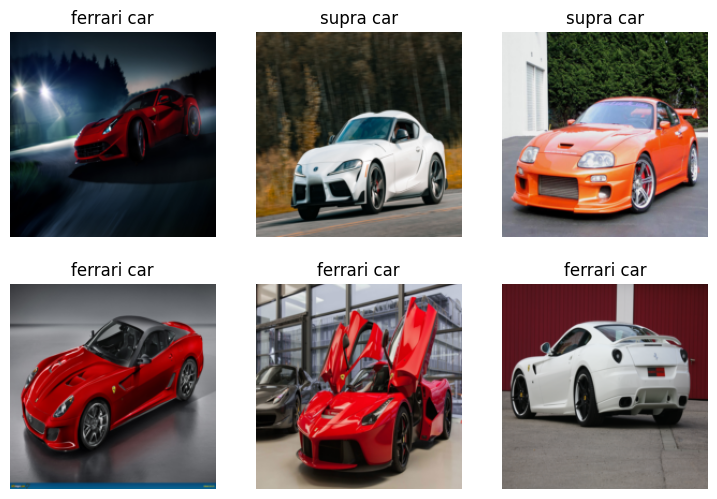

In [84]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(training_data_dir)

dls.show_batch(max_n=6)

In [85]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.070651,1.188653,0.408451,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.550703,0.772166,0.253521,00:19
1,0.438310,0.513677,0.140845,00:19
2,0.328949,0.472702,0.140845,00:20


In [86]:
label_mapping = dict(enumerate(learn.dls.vocab))
label_mapping

{0: 'ferrari car', 1: 'supra car'}

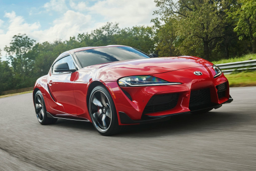

This is a: supra car.
Probability it's a ferrari car: 0.0004
Probability it's a supra car: 0.9996


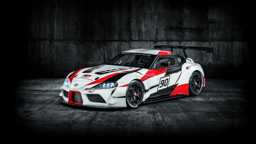

This is a: supra car.
Probability it's a ferrari car: 0.0002
Probability it's a supra car: 0.9998


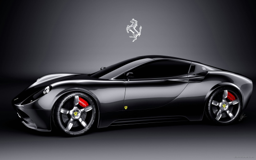

This is a: ferrari car.
Probability it's a ferrari car: 0.7845
Probability it's a supra car: 0.2155


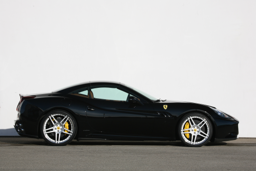

This is a: ferrari car.
Probability it's a ferrari car: 0.8170
Probability it's a supra car: 0.1830


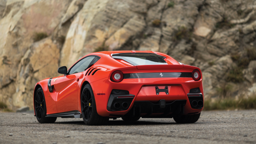

This is a: ferrari car.
Probability it's a ferrari car: 0.7264
Probability it's a supra car: 0.2736


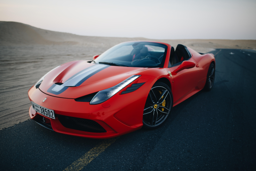

This is a: ferrari car.
Probability it's a ferrari car: 0.9997
Probability it's a supra car: 0.0003


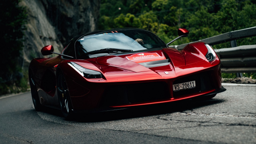

This is a: ferrari car.
Probability it's a ferrari car: 0.9988
Probability it's a supra car: 0.0012


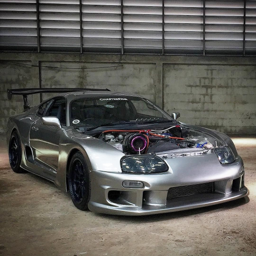

This is a: supra car.
Probability it's a ferrari car: 0.0883
Probability it's a supra car: 0.9117


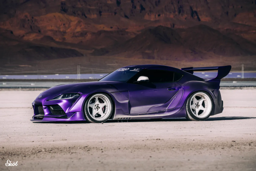

This is a: supra car.
Probability it's a ferrari car: 0.0003
Probability it's a supra car: 0.9997


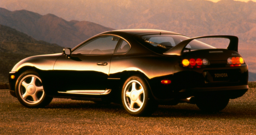

This is a: supra car.
Probability it's a ferrari car: 0.0812
Probability it's a supra car: 0.9188


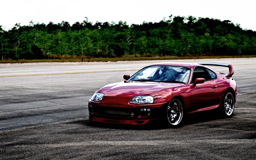

This is a: supra car.
Probability it's a ferrari car: 0.0004
Probability it's a supra car: 0.9996


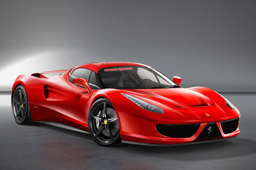

This is a: ferrari car.
Probability it's a ferrari car: 0.9978
Probability it's a supra car: 0.0022


In [87]:
test_files = [f for f in data_dir.glob('*') if f.is_file()]
for file in test_files:
    display(Image.open(file).to_thumb(256,256))
    is_thing,_,probs = learn.predict(PILImage.create(file))
    print(f"This is a: {is_thing}.")
    for i, p in enumerate(probs):
        print(f"Probability it's a {label_mapping[i]}: {p:.4f}")